<a href="https://colab.research.google.com/github/Nannanpeng/Econ_Dynamic_Programming/blob/master/Likelihood_ration_process_and_dp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install --upgrade quantecon
!pip install interpolation

Requirement already up-to-date: quantecon in /usr/local/lib/python3.6/dist-packages (0.4.8)


In [2]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit, prange, jitclass, float64, int64
from interpolation import interp
from math import gamma

In [3]:
wf_data = [('a0', float64),          # Parameters of beta distributions
      ('b0', float64),
      ('a1', float64),
      ('b1', float64),
      ('c', float64),           # Cost of another draw
      ('pi_grid_size', int64),
      ('L0', float64),          # Cost of selecting f0 when f1 is true
      ('L1', float64),          # Cost of selecting f1 when f0 is true
      ('pi_grids', float64[:]),
      ('mc_size', int64),
      ('z0_draws', float64[:]),
      ('z1_draws', float64[:])]

In [13]:
@jitclass(wf_data)
class WaldFriedman:
  def __init__(self, c=1.25,
            a0=1.0,
            b0=1.0,
            a1=3.0,
            b1=1.2,
            L0=25.0,
            L1=25.0,
            pi_grid_size=200,
            mc_size=1000):
    self.c, self.a0, self.b0, self.a1, self.b1 = c, a0, b0, a1, b1
    self.L0, self.L1 = L0, L1
    self.pi_grid_size, self.mc_size = pi_grid_size, mc_size
    self.pi_grids = np.linspace(0, 1, pi_grid_size)
    self.z0_draws = np.random.beta(a0, b0, size=mc_size)
    self.z1_draws = np.random.beta(a1, b1, size=mc_size)

@njit
def p(x, a, b):
  r = gamma(a + b) / (gamma(a) * gamma(b))
  return r * x**(a-1) * (1 - x)**(b-1)

@njit
def compute_weight(z, pi, wf):
  a0, b0, a1, b1 = wf.a0, wf.b0, wf.a1, wf.b1
  num = pi*p(z, a0, b0)
  den = num + (1 - pi)*p(z, a1, b1)
  return num/den

@njit
def state_action_value(pi, h, wf):
  L0, L1, c = wf.L0, wf.L1, wf.c
  z0_draws, z1_draws, mc_size = wf.z0_draws, wf.z1_draws, wf.mc_size
  pi_grids = wf.pi_grids

  H = lambda pi_: interp(pi_grids, h, pi_)
  integral0, integral1 = 0, 0
  for i in range(mc_size):
    pi0 = compute_weight(z0_draws[i], pi, wf)
    integral0 += min((1-pi0)*L0, pi0*L1, H(pi0))
    pi1 = compute_weight(z1_draws[i], pi, wf) 
    integral1 += min((1-pi1)*L0, pi1*L1, H(pi1)) 
  integral = (pi*integral0 + (1-pi)*integral1)/mc_size
  return c + integral

@njit
def Q(h, wf):
  Qh = np.empty_like(h)
  for i, pi in enumerate(wf.pi_grids):
    Qh[i] = state_action_value(pi, h, wf)
  return Qh

def compute_convergence(wf, max_iter=1000, tol=1e-5, verbose=True, print_skip=25):
  h = np.zeros_like(wf.pi_grids)
  err=1+tol
  i=1
  while i < max_iter and err > tol:
    Qh = Q(h, wf)
    err = np.max(np.abs(Qh-h))
    h = Qh
    i += 1
    if verbose and i%print_skip==0:
      print(f"Error is {err} on iteration {i}.")

  if i == max_iter:
    raise RuntimeError('Iteration failed!')
  
  if verbose:
    print(f"\nConverged on iteration {i}!")

  return h

@njit
def compute_value_function(h, wf):
  L0, L1, pi_grids = wf.L0, wf.L1, wf.pi_grids
  H = lambda pi_: interp(pi_grids, h, pi_)
  J = np.empty_like(pi_grids)
  for i, pi in enumerate(pi_grids):
    J[i] = min((1-pi)*L0, pi*L1, H(pi))
  return J

In [15]:
 %%time
 
 wf = WaldFriedman()
 h = compute_convergence(wf)

Error is 0.00013502287849220806 on iteration 25.

Converged on iteration 31!
CPU times: user 5.56 s, sys: 5.91 ms, total: 5.56 s
Wall time: 5.57 s


In [16]:
%%time
j_value = compute_value_function(h, wf)

CPU times: user 160 ms, sys: 3.99 ms, total: 164 ms
Wall time: 164 ms


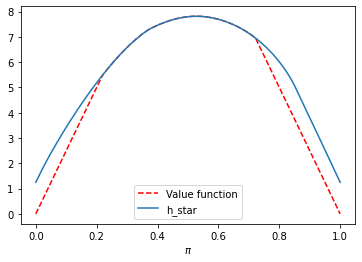

In [23]:
plt.plot(wf.pi_grids, j_value, 'r--', label='Value function')
plt.plot(wf.pi_grids, h, label='h_star')
plt.xlabel(r'$\pi$')
plt.legend();